In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, precision_recall_curve
import seaborn as sns
import cv2
import pandas as pd

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# Normalize and one-hot encode data
x_train, x_test = x_train / 255.0, x_test / 255.0
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [4]:
### Class Distribution Analysis
class_counts = Counter(y_train.argmax(axis=1))
print("Class-wise distribution in training set:", class_counts)

### Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))


Class-wise distribution in training set: Counter({np.int64(6): 5000, np.int64(9): 5000, np.int64(4): 5000, np.int64(1): 5000, np.int64(2): 5000, np.int64(7): 5000, np.int64(8): 5000, np.int64(3): 5000, np.int64(5): 5000, np.int64(0): 5000})


In [5]:
### Define CNN Model
def create_cnn_model():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', name="conv1")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', name="conv2")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', name="conv3")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', name="dense1")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# Create and Compile Model
model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train Model with Class Weights
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), class_weight=class_weights_dict)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.3279 - loss: 1.8109 - val_accuracy: 0.5435 - val_loss: 1.2609
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5437 - loss: 1.2896 - val_accuracy: 0.5909 - val_loss: 1.1181
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6054 - loss: 1.1316 - val_accuracy: 0.6442 - val_loss: 0.9927
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6496 - loss: 1.0022 - val_accuracy: 0.6655 - val_loss: 0.9652
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6849 - loss: 0.9066 - val_accuracy: 0.6839 - val_loss: 0.8906
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7032 - loss: 0.8464 - val_accuracy: 0.7043 - val_loss: 0.8648
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7235 - loss: 0.7934 - val_accuracy: 0.7108 - val_loss: 0.8297
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7458 - loss: 0.7280 

In [8]:
#  EARLY STOPPING CALLBACK ADDED
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# PASSED CALLBACK TO FIT()
model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7852 - loss: 0.6129 - val_accuracy: 0.7298 - val_loss: 0.8373
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7998 - loss: 0.5666 - val_accuracy: 0.7333 - val_loss: 0.8610
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8099 - loss: 0.5401 - val_accuracy: 0.7218 - val_loss: 0.8705
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8186 - loss: 0.5114 - val_accuracy: 0.7281 - val_loss: 0.8611


In [9]:
# Evaluate Model
loss, acc = model.evaluate(x_test, y_test)
print(f"Model Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7320 - loss: 0.8329
Model Accuracy: 0.7298


In [10]:
### Layer-wise and Cumulative Layer Analysis
import gc

# Use a smaller subset
x_subset = x_test[:2000]
y_subset = y_test[:2000]

layer_accuracies = []
layer_outputs = []

for i, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        sub_model = keras.Model(inputs=model.input, outputs=layer.output)
        features = sub_model.predict(x_subset, batch_size=128)

        gap = tf.reduce_mean(features, axis=[1, 2])  # Global Average Pooling
        features_flattened = gap.numpy()

        if layer_outputs:
            features = np.concatenate([layer_outputs[-1], features_flattened], axis=1)
        else:
            features = features_flattened

        layer_outputs.append(features)

        temp_model = keras.Sequential([
            layers.Input(shape=(features.shape[1],)),
            layers.Dense(num_classes, activation='softmax')
        ])
        temp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        temp_model.fit(features, y_subset, epochs=1, verbose=0)
        loss, acc = temp_model.evaluate(features, y_subset, verbose=0)
        layer_accuracies.append((layer.name, acc))

        del temp_model  # 🧹 Memory cleanup
        gc.collect()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


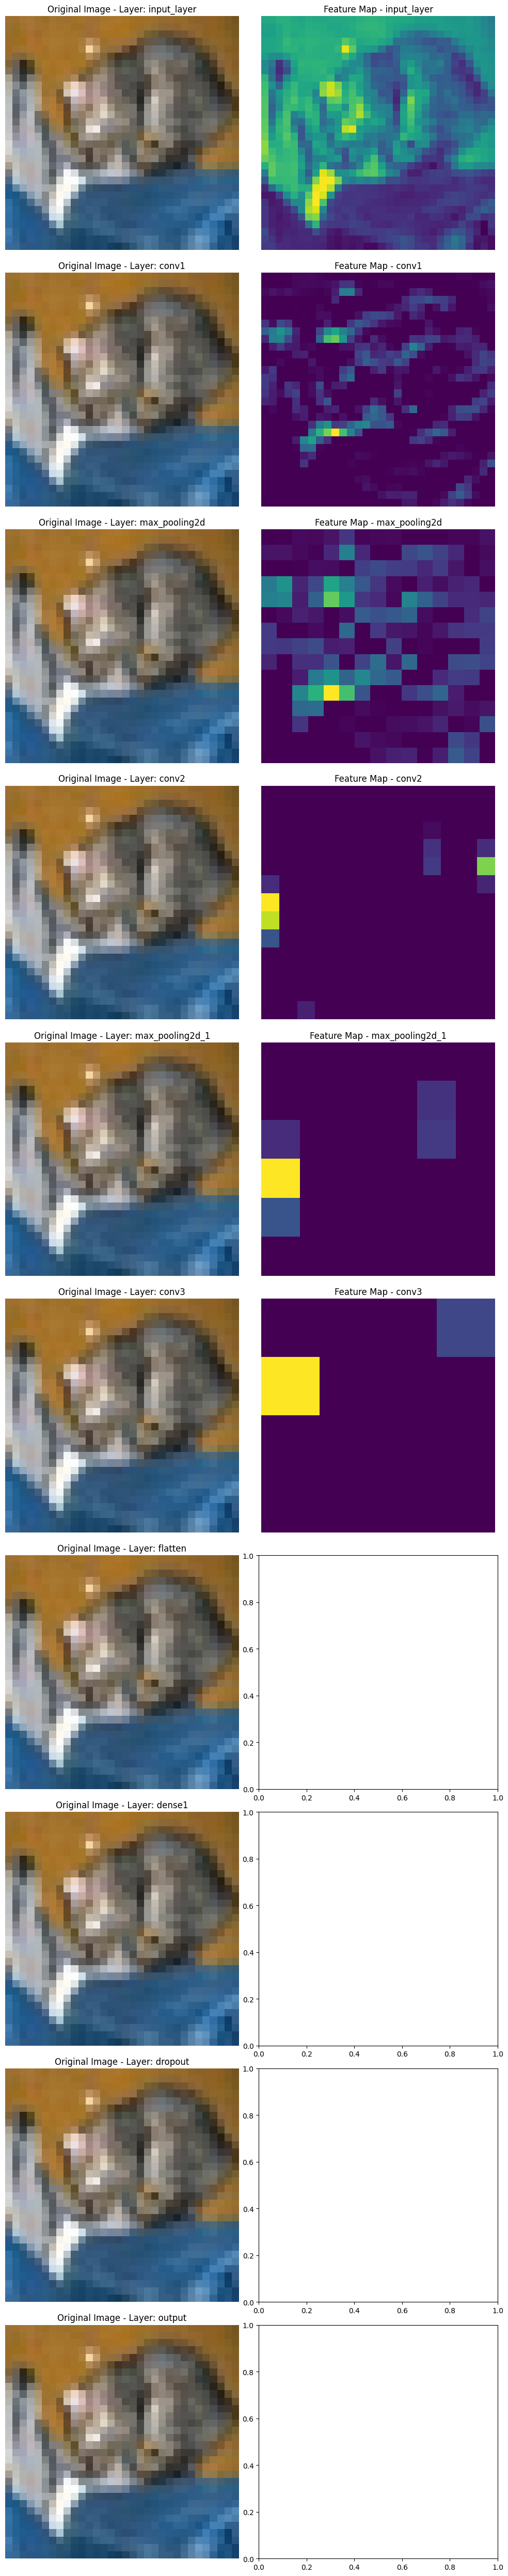

In [11]:
# Visualize Feature Maps
fig, axes = plt.subplots(len(model.layers), 2, figsize=(10, len(model.layers) * 5))
for i, layer in enumerate(model.layers):
    sub_model = keras.Model(inputs=model.input, outputs=layer.output)
    feature_map = sub_model.predict(np.expand_dims(x_test[0], axis=0))
    feature_map = np.squeeze(feature_map)

    axes[i, 0].imshow(x_test[0])
    axes[i, 0].set_title(f"Original Image - Layer: {layer.name}")
    axes[i, 0].axis("off")

    if feature_map.ndim == 3:
        axes[i, 1].imshow(feature_map[:, :, 0], cmap='viridis')
        axes[i, 1].set_title(f"Feature Map - {layer.name}")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [12]:
# intermediate weights
epochs_before_saving = 5

model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(x_train, y_train, epochs=epochs_before_saving, validation_data=(x_test, y_test))

# Save the model weights,  changing the filename to include '.weights' before '.h5'
model.save_weights("intermediate_weights.weights.h5")
print("Intermediate weights saved successfully!")

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3207 - loss: 1.8307 - val_accuracy: 0.5374 - val_loss: 1.2561
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5380 - loss: 1.2915 - val_accuracy: 0.6222 - val_loss: 1.0746
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6117 - loss: 1.1025 - val_accuracy: 0.6603 - val_loss: 0.9690
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6594 - loss: 0.9734 - val_accuracy: 0.6721 - val_loss: 0.9404
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6921 - loss: 0.8913 - val_accuracy: 0.7040 - val_loss: 0.8545
Intermediate weights saved successfully!


In [13]:
# Load the intermediate weights into a new model
new_model = create_cnn_model()
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_model.load_weights("intermediate_weights.weights.h5")  # Correct filename
print("Loaded intermediate weights successfully!")

# Continue training the model for more epochs
new_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Save final model weights
new_model.save_weights("final_model_weights.weights.h5")
print("Final model weights saved successfully!")


Loaded intermediate weights successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7154 - loss: 0.8146 - val_accuracy: 0.7128 - val_loss: 0.8504
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7367 - loss: 0.7565 - val_accuracy: 0.7069 - val_loss: 0.8561
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7544 - loss: 0.7016 - val_accuracy: 0.7228 - val_loss: 0.8140
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7743 - loss: 0.6496 - val_accuracy: 0.7275 - val_loss: 0.8206
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7829 - loss: 0.6153 - val_accuracy: 0.7329 - val_loss: 0.8229
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7971 - loss: 0.5734 - val_accuracy: 0.7286 - val_loss: 0.8469
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8056 - loss: 0.5408 - val_accuracy: 0.7202 - val_loss: 0.8720
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8150 - loss: 0.

In [14]:
# Load final trained weights
new_model.load_weights("final_model_weights.weights.h5")
print("Final model weights loaded.")

# Extract output from 'conv2' layer
conv2_model = keras.Model(inputs=new_model.input, outputs=new_model.get_layer("conv2").output)
x_test_conv2 = conv2_model.predict(x_test)

# Create a simple classifier for conv2 outputs
conv2_classifier = keras.Sequential([
    layers.Flatten(input_shape=x_test_conv2.shape[1:]),
    layers.Dense(num_classes, activation='softmax')
])
conv2_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train or evaluate on conv2 features
conv2_classifier.fit(x_test_conv2, y_test, epochs=1, verbose=1)
loss, acc = conv2_classifier.evaluate(x_test_conv2, y_test)
print(f"Final Model Accuracy (on conv2 output): {acc:.4f}")


Final model weights loaded.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4921 - loss: 1.5571
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7557 - loss: 0.8420
Final Model Accuracy (on conv2 output): 0.7565


In [15]:
# All layers accuracy
for layer_name, accuracy in layer_accuracies:
    print(f"Layer: {layer_name}, Accuracy: {accuracy:.4f}")

Layer: conv1, Accuracy: 0.1070
Layer: conv2, Accuracy: 0.1955
Layer: conv3, Accuracy: 0.3310


In [16]:
### Print Accuracies per Layer and Cumulative ✅
for layer_name, accuracy in layer_accuracies:
    print(f"Layer: {layer_name}, Cumulative Accuracy: {accuracy:.4f}")

Layer: conv1, Cumulative Accuracy: 0.1070
Layer: conv2, Cumulative Accuracy: 0.1955
Layer: conv3, Cumulative Accuracy: 0.3310


In [17]:
# Identify Best Layer
best_layer = max(layer_accuracies, key=lambda x: x[1])
print(f"Best Performing Layer: {best_layer[0]} with Accuracy: {best_layer[1]:.4f}")


Best Performing Layer: conv3 with Accuracy: 0.3310


In [18]:
# Per-Class Precision, Recall, and F1-Score
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, target_names=[
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
])
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

    Airplane       0.69      0.77      0.73      1000
  Automobile       0.82      0.82      0.82      1000
        Bird       0.57      0.62      0.59      1000
         Cat       0.56      0.52      0.54      1000
        Deer       0.69      0.57      0.62      1000
         Dog       0.66      0.57      0.61      1000
        Frog       0.73      0.80      0.77      1000
       Horse       0.80      0.72      0.76      1000
        Ship       0.76      0.84      0.80      1000
       Truck       0.76      0.82      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [19]:
# Class-Based Threshold Tuning
for i in range(num_classes):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_pred[:, i])
    optimal_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Optimal threshold for class {i}: {optimal_threshold}")


Optimal threshold for class 0: 0.463223934173584
Optimal threshold for class 1: 0.3441098928451538
Optimal threshold for class 2: 0.3562357723712921
Optimal threshold for class 3: 0.16881532967090607
Optimal threshold for class 4: 0.20995156466960907
Optimal threshold for class 5: 0.27900806069374084
Optimal threshold for class 6: 0.3810912072658539
Optimal threshold for class 7: 0.26518288254737854
Optimal threshold for class 8: 0.4754316210746765
Optimal threshold for class 9: 0.3398585915565491


In [20]:
# Grad-CAM Implementation
def grad_cam(model, img_array, class_index, layer_name):
    grad_model = keras.models.Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Convert conv_outputs to a NumPy array for in-place modification
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (32, 32))
    return heatmap

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


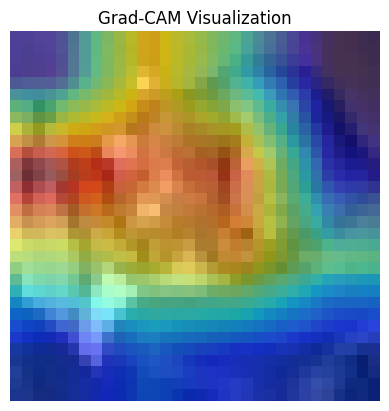

In [21]:
# Display Grad-CAM
img_array = np.expand_dims(x_test[0], axis=0)
heatmap = grad_cam(model, img_array, np.argmax(y_test[0]), 'conv3')
plt.imshow(x_test[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()